In [1]:
import argparse
import datetime
from datetime import date
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy

## disable all warning messages
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages are not printed

## load local files
import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as utils

## version compatibility
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR) # deprecation warning is not printed

ExperimentConfig = expt_settings.configs.ExperimentConfig # defines experiment configs and paths to outputs. experiment config detail is in data_formatter.
ModelClass = libs.tft_model.TemporalFusionTransformer # full TFT architecture with training, evaluation and prediction using Pandas Dataframe inputs
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager # classes used for hyperparameter optimisation on a single machine/GPU
# DistributedHyperparamOptManager = libs.hyperparam_opt.DistributedHyperparamOptManager # for multi GPU --- many errors here, not using at this moment



2023-02-20 02:22:12.236826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
### sample experiment

name='acq_1000'
output_folder='output_2023_02'
use_tensorflow_with_gpu=True
gpu_num='3'

config = ExperimentConfig(experiment=name, root_folder=output_folder)
formatter = config.make_data_formatter()

expt_name=name
use_gpu=use_tensorflow_with_gpu
gpu_number=gpu_num
data_csv_path=config.data_csv_path
data_formatter=formatter
num_repeats=1
use_testing_mode=False

In [3]:
## check whether imported data formatter is a correct class instance.
if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
  raise ValueError(
      "Data formatters should inherit from" +
      "AbstractDataFormatter! Type={}".format(type(data_formatter)))


## Tensorflow setup and
## specifies whether to run graph on gpu or cpu and which GPU ID to use for multi GPU machines.
print("\n\n*** Tensorflow setup ***")
if use_gpu:
      if gpu_number == 'all':
            default_keras_session = tf.keras.backend.get_session() # use all available GPUs
            tf_config = utils.get_default_tensorflow_config(tf_device="gpu")
      else:
            tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=int(gpu_number))
            tf_config.gpu_options.allow_growth = True # single GPU
            default_keras_session = tf.keras.backend.get_session() # use selected GPU
else:
  tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

tf_config



*** Tensorflow setup ***
Selecting GPU ID=3


gpu_options {
  allow_growth: true
}

In [4]:
print("\n\n*** Training from defined parameters for experiment: {} ***".format(expt_name))
print("Loading & splitting data...") ## data_csv_path is in configs file
raw_data = pd.read_csv(data_csv_path, index_col=0) # first column of raw data is index column Unnamed:0

## check
print(raw_data.groupby(['merchant_index'])['merchant_index'].count())
print('There are', raw_data.groupby(['merchant_index'])['merchant_index'].count().shape, 'companies.')
print(raw_data[raw_data['merchant_index']==1001]) # 2016-10-09 - 2020-02-23
raw_data



*** Training from defined parameters for experiment: acq_1000 ***
Loading & splitting data...
merchant_index
11      177
12      177
13      177
15      177
20      177
       ... 
1096    177
1097    177
1098    177
1099    177
1100    177
Name: merchant_index, Length: 1061, dtype: int64
       acq_week  N_week_cohort  initial_order  initial_order_per_cust  \
155  2016-10-09           63.0           63.0                     1.0   
156  2016-10-16           87.0           87.0                     1.0   
157  2016-10-23           68.0           68.0                     1.0   
158  2016-10-30           94.0           94.0                     1.0   
159  2016-11-06           61.0           61.0                     1.0   
..          ...            ...            ...                     ...   
327  2020-01-26           27.0           27.0                     1.0   
328  2020-02-02           26.0           26.0                     1.0   
329  2020-02-09           21.0           21.0      

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
21159,2016-10-09,8826.0,8826.0,1.0,84023.37600,9.519984,10243.0,1.160548,103062.32900,10.061733,0.0,0.0,40.0,0.000000,0.000000,11,itunes,Home Entertainment,Music Streaming & Audio
21160,2016-10-16,8766.0,8766.0,1.0,82170.15500,9.373734,10221.0,1.165982,103860.28300,10.161460,0.0,0.0,41.0,0.005682,0.000032,11,itunes,Home Entertainment,Music Streaming & Audio
21161,2016-10-23,8757.0,8757.0,1.0,83054.18800,9.484320,10176.0,1.162042,104372.14400,10.256697,0.0,0.0,42.0,0.011364,0.000129,11,itunes,Home Entertainment,Music Streaming & Audio
21162,2016-10-30,8794.0,8794.0,1.0,77786.71200,8.845430,10239.0,1.164317,99858.21700,9.752731,0.0,0.0,43.0,0.017045,0.000291,11,itunes,Home Entertainment,Music Streaming & Audio
21163,2016-11-06,7822.0,7822.0,1.0,73670.15000,9.418327,8875.0,1.134620,90579.98950,10.206196,0.0,0.0,44.0,0.022727,0.000517,11,itunes,Home Entertainment,Music Streaming & Audio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19384,2020-01-26,328.0,328.0,1.0,56637.92000,172.676585,352.0,1.073171,60115.34000,170.782216,1.0,0.0,4.0,0.977273,0.955062,1100,hotwire_com,Travel & Transportation,Online Travel Agency
19385,2020-02-02,318.0,318.0,1.0,92580.37125,291.133243,329.0,1.034591,94365.81125,286.826174,1.0,0.0,5.0,0.982955,0.966200,1100,hotwire_com,Travel & Transportation,Online Travel Agency
19386,2020-02-09,389.0,389.0,1.0,82226.75425,211.379831,417.0,1.071979,86274.30425,206.892816,1.0,0.0,6.0,0.988636,0.977402,1100,hotwire_com,Travel & Transportation,Online Travel Agency
19387,2020-02-16,400.0,400.0,1.0,83283.79425,208.209486,424.0,1.060000,86651.71425,204.367251,1.0,0.0,7.0,0.994318,0.988669,1100,hotwire_com,Travel & Transportation,Online Travel Agency


In [5]:
## limit to which has validation data
validation_start = '2018-11-18'
merchant_list=raw_data[raw_data['acq_week']<validation_start].groupby(['merchant_index'], as_index=False)['acq_week'].count()
raw_data=pd.merge(raw_data, merchant_list['merchant_index'], on='merchant_index').drop_duplicates()
print(raw_data.groupby(['merchant_index'])['merchant_index'].count())
raw_data

merchant_index
11      177
12      177
13      177
15      177
20      177
       ... 
1096    177
1097    177
1098    177
1099    177
1100    177
Name: merchant_index, Length: 1059, dtype: int64


,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
0,2016-10-09,8826.0,8826.0,1.0,84023.37600,9.519984,10243.0,1.160548,103062.32900,10.061733,0.0,0.0,40.0,0.000000,0.000000,11,itunes,Home Entertainment,Music Streaming & Audio
1,2016-10-16,8766.0,8766.0,1.0,82170.15500,9.373734,10221.0,1.165982,103860.28300,10.161460,0.0,0.0,41.0,0.005682,0.000032,11,itunes,Home Entertainment,Music Streaming & Audio
2,2016-10-23,8757.0,8757.0,1.0,83054.18800,9.484320,10176.0,1.162042,104372.14400,10.256697,0.0,0.0,42.0,0.011364,0.000129,11,itunes,Home Entertainment,Music Streaming & Audio
3,2016-10-30,8794.0,8794.0,1.0,77786.71200,8.845430,10239.0,1.164317,99858.21700,9.752731,0.0,0.0,43.0,0.017045,0.000291,11,itunes,Home Entertainment,Music Streaming & Audio
4,2016-11-06,7822.0,7822.0,1.0,73670.15000,9.418327,8875.0,1.134620,90579.98950,10.206196,0.0,0.0,44.0,0.022727,0.000517,11,itunes,Home Entertainment,Music Streaming & Audio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185203,2020-01-26,328.0,328.0,1.0,56637.92000,172.676585,352.0,1.073171,60115.34000,170.782216,1.0,0.0,4.0,0.977273,0.955062,1100,hotwire_com,Travel & Transportation,Online Travel Agency
185204,2020-02-02,318.0,318.0,1.0,92580.37125,291.133243,329.0,1.034591,94365.81125,286.826174,1.0,0.0,5.0,0.982955,0.966200,1100,hotwire_com,Travel & Transportation,Online Travel Agency
185205,2020-02-09,389.0,389.0,1.0,82226.75425,211.379831,417.0,1.071979,86274.30425,206.892816,1.0,0.0,6.0,0.988636,0.977402,1100,hotwire_com,Travel & Transportation,Online Travel Agency
185206,2020-02-16,400.0,400.0,1.0,83283.79425,208.209486,424.0,1.060000,86651.71425,204.367251,1.0,0.0,7.0,0.994318,0.988669,1100,hotwire_com,Travel & Transportation,Online Travel Agency


In [6]:
print(" - Data is located in: ", data_csv_path)
train, valid, test = data_formatter.split_data(raw_data) # set validation start, test start, test end in data_formatter file
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration() # if subsampling data

print(train_samples) # -1 for using all available samples
print(valid_samples)

 - Data is located in:  output_2023_02/../data/preprocessed_data/tft_google/company_0_1000_acq_initaov.csv
Formatting train-valid-test splits.
Setting scalers with training data...
-1
-1


In [7]:
## check
print(train.groupby(['merchant_index'])['merchant_index'].count())
print(valid.groupby(['merchant_index'])['merchant_index'].count())
print(test.groupby(['merchant_index'])['merchant_index'].count())
print(train[train['merchant_index']==1001]) # ~ 2018-11-11
train


merchant_index
11      110
12      110
13      110
15      110
20      110
       ... 
1096    110
1097    110
1098    110
1099    110
1100    110
Name: merchant_index, Length: 1059, dtype: int64
merchant_index
11      20
12      20
13      20
15      20
20      20
        ..
1096    20
1097    20
1098    20
1099    20
1100    20
Name: merchant_index, Length: 1059, dtype: int64
merchant_index
11      47
12      47
13      47
15      47
20      47
        ..
1096    47
1097    47
1098    47
1099    47
1100    47
Name: merchant_index, Length: 1059, dtype: int64
          acq_week  N_week_cohort  initial_order  initial_order_per_cust  \
167810  2016-10-09      -0.711678           63.0                     1.0   
167811  2016-10-16      -0.699431           87.0                     1.0   
167812  2016-10-23      -0.709127           68.0                     1.0   
167813  2016-10-30      -0.695859           94.0                     1.0   
167814  2016-11-06      -0.712699           61.0      

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
0,2016-10-09,3.760030,8826.0,1.0,84023.37600,9.519984,10243.0,1.160548,103062.32900,10.061733,-1.962104,0,34,-1.711072,-1.107820,11,itunes,16,76
1,2016-10-16,3.729412,8766.0,1.0,82170.15500,9.373734,10221.0,1.165982,103860.28300,10.161460,-1.962104,0,35,-1.679547,-1.107540,11,itunes,16,76
2,2016-10-23,3.724819,8757.0,1.0,83054.18800,9.484320,10176.0,1.162042,104372.14400,10.256697,-1.962104,0,36,-1.648021,-1.106699,11,itunes,16,76
3,2016-10-30,3.743700,8794.0,1.0,77786.71200,8.845430,10239.0,1.164317,99858.21700,9.752731,-1.962104,0,37,-1.616495,-1.105297,11,itunes,16,76
4,2016-11-06,3.247694,7822.0,1.0,73670.15000,9.418327,8875.0,1.134620,90579.98950,10.206196,-1.962104,0,38,-1.584969,-1.103335,11,itunes,16,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185136,2018-10-14,-0.524910,429.0,1.0,117223.49975,273.248251,454.0,1.058275,120252.38975,264.873105,1.076618,0,35,1.599131,1.982707,1100,hotwire_com,24,82
185137,2018-10-21,-0.559100,362.0,1.0,80327.77275,221.899925,381.0,1.052486,82642.93275,216.910585,1.076618,0,36,1.630656,2.041855,1100,hotwire_com,24,82
185138,2018-10-28,-0.536647,406.0,1.0,77097.31425,189.894863,435.0,1.071429,81320.62425,186.943964,1.076618,0,37,1.662182,2.101563,1100,hotwire_com,24,82
185139,2018-11-04,-0.543791,392.0,1.0,76410.52425,194.924807,409.0,1.043367,78301.92425,191.447248,1.076618,0,38,1.693708,2.161832,1100,hotwire_com,24,82


In [8]:
train.iloc[:20]

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
0,2016-10-09,3.760030,8826.0,1.0,84023.3760,9.519984,10243.0,1.160548,103062.32900,10.061733,-1.962104,0,34,-1.711072,-1.107820,11,itunes,16,76
1,2016-10-16,3.729412,8766.0,1.0,82170.1550,9.373734,10221.0,1.165982,103860.28300,10.161460,-1.962104,0,35,-1.679547,-1.107540,11,itunes,16,76
2,2016-10-23,3.724819,8757.0,1.0,83054.1880,9.484320,10176.0,1.162042,104372.14400,10.256697,-1.962104,0,36,-1.648021,-1.106699,11,itunes,16,76
3,2016-10-30,3.743700,8794.0,1.0,77786.7120,8.845430,10239.0,1.164317,99858.21700,9.752731,-1.962104,0,37,-1.616495,-1.105297,11,itunes,16,76
4,2016-11-06,3.247694,7822.0,1.0,73670.1500,9.418327,8875.0,1.134620,90579.98950,10.206196,-1.962104,0,38,-1.584969,-1.103335,11,itunes,16,76
5,2016-11-13,4.035588,9366.0,1.0,85990.2900,9.181111,10836.0,1.156951,106176.58500,9.798504,-1.962104,0,39,-1.553444,-1.100812,11,itunes,16,76
6,2016-11-20,4.217763,9723.0,1.0,90021.3370,9.258597,11378.0,1.170215,119065.15000,10.464506,-1.962104,0,40,-1.521918,-1.097728,11,itunes,16,76
7,2016-11-27,4.079474,9452.0,1.0,85220.0540,9.016087,11034.0,1.167372,105144.85750,9.529170,-1.962104,0,41,-1.490392,-1.094084,11,itunes,16,76
8,2016-12-04,3.674811,8659.0,1.0,78309.2532,9.043683,10091.0,1.165377,97745.56940,9.686411,-1.962104,0,42,-1.458866,-1.089880,11,itunes,16,76
9,2016-12-11,4.008033,9312.0,1.0,84319.0763,9.054884,10843.0,1.164412,104335.32710,9.622367,-1.962104,0,43,-1.427341,-1.085114,11,itunes,16,76


In [9]:
## check
print(valid.groupby(['merchant_index'])['merchant_index'].count())
valid

merchant_index
11      20
12      20
13      20
15      20
20      20
        ..
1096    20
1097    20
1098    20
1099    20
1100    20
Name: merchant_index, Length: 1059, dtype: int64


,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
110,2018-11-18,0.503332,2444.0,1.0,26730.82840,10.937327,2819.0,1.153437,32676.09300,11.591377,1.076618,0,40,1.756759,2.284051,11,itunes,16,76
111,2018-11-25,0.616107,2665.0,1.0,26415.70725,9.912085,3108.0,1.166229,33167.39070,10.671619,1.076618,0,41,1.788285,2.346002,11,itunes,16,76
112,2018-12-02,0.531398,2499.0,1.0,24179.09300,9.675507,2860.0,1.144458,29788.13700,10.415433,1.076618,0,42,1.819811,2.408513,11,itunes,16,76
113,2018-12-09,0.474756,2388.0,1.0,21068.97800,8.822855,2796.0,1.170854,25554.16900,9.139545,1.076618,0,43,1.851337,2.471585,11,itunes,16,76
114,2018-12-16,0.583959,2602.0,1.0,22875.39200,8.791465,3220.0,1.237510,28033.54400,8.706070,1.076618,0,45,1.882862,2.535218,11,itunes,16,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185156,2019-03-03,-0.507560,463.0,1.0,110644.49700,238.972996,494.0,1.066955,115619.08700,234.046735,2.595978,0,51,2.229646,3.272179,1100,hotwire_com,24,82
185157,2019-03-10,-0.466227,544.0,1.0,179794.13100,330.503917,566.0,1.040441,183524.90100,324.248942,2.595978,0,1,2.261171,3.342539,1100,hotwire_com,24,82
185158,2019-03-17,-0.499906,478.0,1.0,96763.48425,202.434067,498.0,1.041841,99503.66425,199.806555,2.595978,0,2,2.292697,3.413460,1100,hotwire_com,24,82
185159,2019-03-24,-0.509602,459.0,1.0,123971.47975,270.090370,480.0,1.045752,132816.26400,276.700550,2.595978,0,3,2.324223,3.484942,1100,hotwire_com,24,82


In [10]:
## check
print(test.groupby(['merchant_index'])['merchant_index'].count())
test

merchant_index
11      47
12      47
13      47
15      47
20      47
        ..
1096    47
1097    47
1098    47
1099    47
1100    47
Name: merchant_index, Length: 1059, dtype: int64


,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
130,2019-04-07,0.355857,2155.0,1.0,29251.09290,13.573593,2582.0,1.198144,33043.11290,12.797488,2.595978,0,5,2.387274,3.629587,11,itunes,16,76
131,2019-04-14,0.361471,2166.0,1.0,27022.39600,12.475714,2634.0,1.216066,32849.50520,12.471338,2.595978,0,6,2.418800,3.702750,11,itunes,16,76
132,2019-04-21,0.334935,2114.0,1.0,23079.10990,10.917271,2610.0,1.234626,27470.64450,10.525151,2.595978,0,7,2.450326,3.776474,11,itunes,16,76
133,2019-04-28,0.298704,2043.0,1.0,24857.58140,12.167196,2542.0,1.244249,30208.20830,11.883638,2.595978,0,8,2.481851,3.850759,11,itunes,16,76
134,2019-05-05,0.263494,1974.0,1.0,32037.50800,16.229741,2333.0,1.181864,36269.75640,15.546402,2.595978,0,9,2.513377,3.925605,11,itunes,16,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185203,2020-01-26,-0.576450,328.0,1.0,56637.92000,172.676585,352.0,1.073171,60115.34000,170.782216,4.115339,0,33,3.711355,7.185165,1100,hotwire_com,24,82
185204,2020-02-02,-0.581553,318.0,1.0,92580.37125,291.133243,329.0,1.034591,94365.81125,286.826174,4.115339,0,44,3.742881,7.281875,1100,hotwire_com,24,82
185205,2020-02-09,-0.545322,389.0,1.0,82226.75425,211.379831,417.0,1.071979,86274.30425,206.892816,4.115339,0,48,3.774407,7.379146,1100,hotwire_com,24,82
185206,2020-02-16,-0.539709,400.0,1.0,83283.79425,208.209486,424.0,1.060000,86651.71425,204.367251,4.115339,0,49,3.805933,7.476978,1100,hotwire_com,24,82


In [11]:
## Sets up default params
# data specific data formatter should define these 5 fixed_params: total time steps of TFT, num LSTM encoder steps, max num epochs, early stopping patience, CPU multiprocessing workers
fixed_params = data_formatter.get_experiment_params() # Returns fixed model parameters for experiments.
# data specific data formatter can flexibly have model_params:
params = data_formatter.get_default_model_params() # Returns default optimised model parameters.

print(fixed_params)
print(params)

{'total_time_steps': 15, 'num_encoder_steps': 12, 'num_epochs': 10, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('merchant_index', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('holidays', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('weekofyear', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('category', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('subcategory', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 8, 'output_size': 1, 'category_counts': [2, 52, 25, 121], 'input_obs_loc': [0], 'static_input_loc': [6, 7], 'known_regular_inputs': [1, 2, 3]

In [12]:
## Folder path where models are serialized
model_folder = os.path.join(config.model_folder, datetime.datetime.now().strftime("%Y-%m-%d_%H_%M"))
params["model_folder"] = model_folder
print("Model will be saved in: ", model_folder)

## Parameter overrides for testing only! Small sizes used to speed up script.
if use_testing_mode:
  fixed_params["num_epochs"] = 1
  params["hidden_layer_size"] = 5
  train_samples, valid_samples = 100, 10

## Sets up hyperparam manager
print("\n*** Loading hyperparm manager ***")

# opt_manager = DistributedHyperparamOptManager({k: [params[k]] for k in params}, fixed_params, model_folder) ## Error- nont using distributed optimization
opt_manager = HyperparamOptManager({k: [params[k]] for k in params}, fixed_params, model_folder)
opt_manager

Model will be saved in:  output_2023_02/saved_models/acq_1000/2023-02-20_02_22

*** Loading hyperparm manager ***


In [13]:
print(opt_manager.hyperparam_folder)
print(opt_manager.param_ranges)

print(opt_manager.results)
print(opt_manager.saved_params)


output_2023_02/saved_models/acq_1000/2023-02-20_02_22
{'dropout_rate': [0.2], 'hidden_layer_size': [160], 'learning_rate': [0.001], 'minibatch_size': [256], 'max_gradient_norm': [100.0], 'num_heads': [4], 'stack_size': [1], 'model_folder': ['output_2023_02/saved_models/acq_1000/2023-02-20_02_22']}
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


In [14]:
params=opt_manager.get_next_parameters()
params

{'dropout_rate': 0.2,
 'hidden_layer_size': 160,
 'learning_rate': 0.001,
 'max_gradient_norm': 100.0,
 'minibatch_size': 256,
 'model_folder': 'output_2023_02/saved_models/acq_1000/2023-02-20_02_22',
 'num_heads': 4,
 'stack_size': 1,
 'total_time_steps': 15,
 'num_encoder_steps': 12,
 'num_epochs': 10,
 'early_stopping_patience': 5,
 'multiprocessing_workers': 5,
 'column_definition': [('merchant_index',
   <DataTypes.CATEGORICAL: 1>,
   <InputTypes.ID: 4>),
  ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>),
  ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>),
  ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('holidays', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('weekofyear', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('category', <DataTypes.CATEGORICAL: 1>,

In [15]:
tf.reset_default_graph()
with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    # set session on keras
    tf.keras.backend.set_session(sess)

    # set initial parameter, model, training data
    params = opt_manager.get_next_parameters() # get initialized parameters from random search in new iteration
    model = ModelClass(params, use_cudnn=use_gpu)

model




 Serialization. Resetting temporary folder for Keras training outputs...


*** TemporalFusionTransformer params in initiating process***
# dropout_rate = 0.2
# hidden_layer_size = 160
# learning_rate = 0.001
# max_gradient_norm = 100.0
# minibatch_size = 256
# model_folder = output_2023_02/saved_models/acq_1000/2023-02-20_02_22
# num_heads = 4
# stack_size = 1
# total_time_steps = 15
# num_encoder_steps = 12
# num_epochs = 10
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('merchant_index', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('holidays', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('weekofyea

In [16]:
model.training_data_cached()

False

In [17]:
model._batch_data
model._batch_sampled_data

<bound method TemporalFusionTransformer._batch_sampled_data of <libs.tft_model.TemporalFusionTransformer object at 0x7fa14cfba640>>

In [18]:
model.cache_batched_data(train, "train", num_samples=-1)
model.cache_batched_data(valid, "valid", num_samples=-1)

Cached data "train" updated
Cached data "valid" updated


### Study input data to fitting process

In [19]:
train_data, valid_data, data, labels, active_flags, val_data, val_labels, val_flags = model.get_data_to_fit()


Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit


In [20]:
print(type(train_data))
print(train_data.keys()) # dict_keys(['identifier', 'time', 'outputs', 'inputs', 'active_entries'])
print(train_data['identifier'].shape) # (sample, total_time_steps = encoder+decoder, 1)
print(train_data['time'].shape) # (sample, total_time_steps = encoder+decoder, 1)
print(train_data['inputs'].shape) # (sample, total_time_steps = encoder+decoder, traget + input features)
print(train_data['outputs'].shape) # (sample, decoder, 1)
print(train_data['active_entries'].shape) # (sample, decoder, 1)

print(valid_data.keys()) # dict_keys(['identifier', 'time', 'outputs', 'inputs', 'active_entries'])
print(valid_data['identifier'].shape) # (sample, total_time_steps = encoder+decoder, 1)
print(valid_data['time'].shape) # (sample, total_time_steps = encoder+decoder, 1)
print(valid_data['inputs'].shape) # (sample, total_time_steps = encoder+decoder, traget + input features)
print(valid_data['outputs'].shape) # (sample, decoder, 1)
print(valid_data['active_entries'].shape) # (sample, decoder, 1)

print(data.shape) # data == train_data['inputs']
print(labels.shape) # labels == train_data['outputs']
print(active_flags.shape) # labels == train_data['active_entries']

print(val_data.shape) # data == valid_data['inputs']
print(val_labels.shape) # labels == valid_data['outputs']
print(val_flags.shape) # labels == valid_data['active_entries']

<class 'dict'>
dict_keys(['identifier', 'time', 'outputs', 'inputs', 'active_entries'])
(99447, 15, 1)
(99447, 15, 1)
(99447, 15, 8)
(99447, 3, 1)
(99447, 3, 1)
dict_keys(['identifier', 'time', 'outputs', 'inputs', 'active_entries'])
(6354, 15, 1)
(6354, 15, 1)
(6354, 15, 8)
(6354, 3, 1)
(6354, 3, 1)
(99447, 15, 8)
(99447, 3, 1)
(99447, 3)
(6354, 15, 8)
(6354, 3, 1)
(6354, 3)


In [21]:
# print(train_data['identifier'][0])
# print(train_data['identifier'][841])
# print(train_data['identifier'][842])
# print(train_data['identifier'][train_data['identifier'].shape[0]-1])

# print(train_data['time'][0])
# print(train_data['time'][1]) # sliding by one week
# print(train_data['time'][841])
# print(train_data['time'][842])
# print(train_data['time'][train_data['identifier'].shape[0]-1])

In [22]:
# print(train_data['inputs'][0]) # N_week_cohort, year, linear, linear_1, holidays, weekofyear, category, subcategory
# print(train_data['inputs'][1]) # sliding by one week
# print(train_data['inputs'][train_data['identifier'].shape[0]-1])

In [23]:
# print(train_data['outputs'][0])
# print(train_data['outputs'][1]) # sliding by one week
# print(train_data['outputs'][train_data['identifier'].shape[0]-1])

# print(train_data['active_entries'][0])
# print(train_data['active_entries'][1]) # sliding by one week
# print(train_data['active_entries'][train_data['active_entries'].shape[0]-1])



*** Running calibration ***


 Serialization. Resetting temporary folder for Keras training outputs...


*** TemporalFusionTransformer params in initiating process***
# dropout_rate = 0.2
# hidden_layer_size = 160
# learning_rate = 0.001
# max_gradient_norm = 100.0
# minibatch_size = 256
# model_folder = output_2023_02/saved_models/acq_1000/2023-02-20_02_22
# num_heads = 4
# stack_size = 1
# total_time_steps = 15
# num_encoder_steps = 12
# num_epochs = 10
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('merchant_index', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('holidays', <DataTypes.CATEGORICAL: 1>, <InputTypes

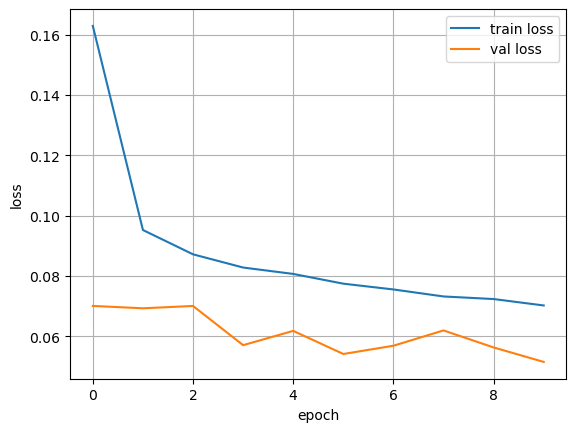

Using cached validation data
Optimal model found, updating
Model saved to: output_2023_02/saved_models/acq_1000/2023-02-20_02_22/TemporalFusionTransformer.ckpt

* Iteration <bound method TemporalFusionTransformer._batch_sampled_data of <libs.tft_model.TemporalFusionTransformer object at 0x7fa14cfba640>> is done.


In [24]:
#====================================================
print("\n\n*** Running calibration ***")
## For each iteration, we start with different initialization to find best parameters set
## that provides smallest local minimum of validation loss.
num_repeats = num_repeats # Training -- one iteration only
best_loss = np.Inf


tf.reset_default_graph()
with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    # set session on keras
    tf.keras.backend.set_session(sess)

    # set initial parameter, model, training data
    params = opt_manager.get_next_parameters() # get initialized parameters from random search in new iteration
    model = ModelClass(params, use_cudnn=use_gpu)
    if not model.training_data_cached():
        # Data to batch and cache & Maximum number of samples to extract (-1 to use all data)
        # model.cache_batched_data(train, "train", num_samples=train_samples)
        # model.cache_batched_data(valid, "valid", num_samples=valid_samples)
        model.cache_batched_data(train, "train", num_samples=-1)
        model.cache_batched_data(valid, "valid", num_samples=-1)

    # run session with initialization
    sess.run(tf.global_variables_initializer())

    model.fit()

    val_loss = model.evaluate()

    if val_loss < best_loss:
        opt_manager.update_score(params, val_loss, model)
        best_loss = val_loss

    tf.keras.backend.set_session(default_keras_session)

    print('\n* Iteration ' + str(_) + ' is done.')


In [25]:
tf.reset_default_graph()
with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
  # set session on keras
  tf.keras.backend.set_session(sess)
  
  best_params = opt_manager.get_best_params()
  model = ModelClass(best_params, use_cudnn=use_gpu)

  model.load(opt_manager.hyperparam_folder)
  
  val_loss2 = model.evaluate(valid)

print(val_loss)
print(val_loss2) # same with val_loss




 Serialization. Resetting temporary folder for Keras training outputs...


*** TemporalFusionTransformer params in initiating process***
# dropout_rate = 0.2
# hidden_layer_size = 160
# learning_rate = 0.001
# max_gradient_norm = 100.0
# minibatch_size = 256
# model_folder = output_2023_02/saved_models/acq_1000/2023-02-20_02_22
# num_heads = 4
# stack_size = 1
# total_time_steps = 15
# num_encoder_steps = 12
# num_epochs = 10
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('merchant_index', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('holidays', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('weekofyea

# One sample Prediction roll out check (after training model)

In [26]:
valid_test_data = pd.concat([valid, test])

# build time frame
prediction_timeframe = pd.concat([valid,test]).acq_week.unique()
prediction_timeframe.sort()

prediction_timeframe = prediction_timeframe[-params['num_encoder_steps']-len(test.acq_week.unique()):]
# np.append(prediction_timeframe, str(datetime.datetime.strptime(prediction_timeframe[-1], '%Y-%m-%d').date() + datetime.timedelta(7)))
print(len(prediction_timeframe))
prediction_timeframe


59


array(['2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03',
       '2019-02-10', '2019-02-17', '2019-02-24', '2019-03-03',
       '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
       '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
       '2019-05-05', '2019-05-12', '2019-05-19', '2019-05-26',
       '2019-06-02', '2019-06-09', '2019-06-16', '2019-06-23',
       '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21',
       '2019-07-28', '2019-08-04', '2019-08-11', '2019-08-18',
       '2019-08-25', '2019-09-01', '2019-09-08', '2019-09-15',
       '2019-09-22', '2019-09-29', '2019-10-06', '2019-10-13',
       '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10',
       '2019-11-17', '2019-11-24', '2019-12-01', '2019-12-08',
       '2019-12-15', '2019-12-22', '2019-12-29', '2020-01-05',
       '2020-01-12', '2020-01-19', '2020-01-26', '2020-02-02',
       '2020-02-09', '2020-02-16', '2020-02-23'], dtype=object)

In [27]:
#====================================================
print("\n\n*** Running tests ***")

tf.reset_default_graph()
with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
  
  t = datetime.datetime.now()
  
  # set session on keras
  tf.keras.backend.set_session(sess)
  
  print('\n starting session ',datetime.datetime.now()-t)
  
  best_params = opt_manager.get_best_params()
  model = ModelClass(best_params, use_cudnn=use_gpu)
  model.load(opt_manager.hyperparam_folder) # output_2023_02/saved_models/acq_1000/2023-02-19_20_17

  print('\n configuring and loading model ', datetime.datetime.now()-t)
  
  ### one sample
  test_batch_data, test_combined, test_predicted = model.predict(valid_test_data[valid_test_data['acq_week']>='2019-11-17'], return_targets=True)
  # test_batch_data, test_combined, test_predicted = model.predict(valid_test_data[valid_test_data['acq_week']>='2019-01-13'], return_targets=True) ## same with this results for last prediction value
  
  print('\n predicting ', datetime.datetime.now()-t)



*** Running tests ***

 starting session  0:00:00.000016


 Serialization. Resetting temporary folder for Keras training outputs...


*** TemporalFusionTransformer params in initiating process***
# dropout_rate = 0.2
# hidden_layer_size = 160
# learning_rate = 0.001
# max_gradient_norm = 100.0
# minibatch_size = 256
# model_folder = output_2023_02/saved_models/acq_1000/2023-02-20_02_22
# num_heads = 4
# stack_size = 1
# total_time_steps = 15
# num_encoder_steps = 12
# num_epochs = 10
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('merchant_index', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('holidays', <DataTypes

In [28]:
print(test_batch_data.keys()) # dict_keys(['identifier', 'time', 'outputs', 'inputs', 'active_entries'])
print(test_batch_data['identifier'].shape) # (sample, total_time_steps = encoder+decoder, 1)
print(test_batch_data['time'].shape) # (sample, total_time_steps = encoder+decoder, 1)
print(test_batch_data['inputs'].shape) # (sample, total_time_steps = encoder+decoder, target + input features)
print(test_batch_data['outputs'].shape) # (sample, decoder steps, 1)
print(test_combined.shape) # (sample, decoder steps, quantile)
print(test_predicted['p50'].shape)

temp=test_predicted['p50']
temp['merchant_index'] = temp['identifier']
predicted_week = str(datetime.datetime.strptime(temp['forecast_time'][0], '%Y-%m-%d').date() + datetime.timedelta(7))
temp['acq_week'] = predicted_week
print(temp)

# merge -- conditional replacement
replacement = pd.merge(valid_test_data, temp[['acq_week', 'merchant_index', 't+0']], 
                       on=['acq_week', 'merchant_index'])
print(replacement)
replacement = replacement.drop('N_week_cohort', axis=1)
replacement = replacement.rename({'t+0': 'N_week_cohort'}, axis=1)

print(valid_test_data.shape)
## update with prediction replaced data
pd.concat([valid_test_data[valid_test_data['acq_week']!=predicted_week], 
           replacement]).sort_values(['merchant_index','acq_week'])


dict_keys(['identifier', 'time', 'outputs', 'inputs', 'active_entries'])
(1059, 15, 1)
(1059, 15, 1)
(1059, 15, 8)
(1059, 3, 1)
(1059, 3, 3)
(1059, 5)
     forecast_time  identifier       t+0       t+1       t+2  merchant_index  \
0       2020-02-02          11  0.258993  0.315318  0.319949              11   
1       2020-02-02          12 -0.394414 -0.371097 -0.378803              12   
2       2020-02-02          13 -0.407903 -0.383504 -0.389116              13   
3       2020-02-02          15  0.000697  0.035104  0.028172              15   
4       2020-02-02          20  0.353625  0.189385  0.067205              20   
...            ...         ...       ...       ...       ...             ...   
1054    2020-02-02        1096 -0.605000 -0.600302 -0.601591            1096   
1055    2020-02-02        1097 -0.639666 -0.631735 -0.632972            1097   
1056    2020-02-02        1098 -0.473006 -0.459401 -0.462604            1098   
1057    2020-02-02        1099 -0.707366 -0.69921

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
110,2018-11-18,0.503332,2444.0,1.0,26730.82840,10.937327,2819.0,1.153437,32676.09300,11.591377,1.076618,0,40,1.756759,2.284051,11,itunes,16,76
111,2018-11-25,0.616107,2665.0,1.0,26415.70725,9.912085,3108.0,1.166229,33167.39070,10.671619,1.076618,0,41,1.788285,2.346002,11,itunes,16,76
112,2018-12-02,0.531398,2499.0,1.0,24179.09300,9.675507,2860.0,1.144458,29788.13700,10.415433,1.076618,0,42,1.819811,2.408513,11,itunes,16,76
113,2018-12-09,0.474756,2388.0,1.0,21068.97800,8.822855,2796.0,1.170854,25554.16900,9.139545,1.076618,0,43,1.851337,2.471585,11,itunes,16,76
114,2018-12-16,0.583959,2602.0,1.0,22875.39200,8.791465,3220.0,1.237510,28033.54400,8.706070,1.076618,0,45,1.882862,2.535218,11,itunes,16,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185203,2020-01-26,-0.576450,328.0,1.0,56637.92000,172.676585,352.0,1.073171,60115.34000,170.782216,4.115339,0,33,3.711355,7.185165,1100,hotwire_com,24,82
185204,2020-02-02,-0.581553,318.0,1.0,92580.37125,291.133243,329.0,1.034591,94365.81125,286.826174,4.115339,0,44,3.742881,7.281875,1100,hotwire_com,24,82
1058,2020-02-09,-0.553180,389.0,1.0,82226.75425,211.379831,417.0,1.071979,86274.30425,206.892816,4.115339,0,48,3.774407,7.379146,1100,hotwire_com,24,82
185206,2020-02-16,-0.539709,400.0,1.0,83283.79425,208.209486,424.0,1.060000,86651.71425,204.367251,4.115339,0,49,3.805933,7.476978,1100,hotwire_com,24,82


In [29]:
### sanity check
print(test_predicted['targets'].iloc[-1])
test[['acq_week','N_week_cohort','merchant_index']].iloc[-4:]

forecast_time    2020-02-02
identifier             1100
t+0               -0.545322
t+1               -0.539709
t+2               -0.533075
Name: 1058, dtype: object


,acq_week,N_week_cohort,merchant_index
185204,2020-02-02,-0.581553,1100
185205,2020-02-09,-0.545322,1100
185206,2020-02-16,-0.539709,1100
185207,2020-02-23,-0.533075,1100


# Real prediction rollout

In [32]:
valid_test_data = pd.concat([valid, test])

tf.reset_default_graph()
with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
  # set session on keras
  tf.keras.backend.set_session(sess)
  
  best_params = opt_manager.get_best_params()
  model = ModelClass(best_params, use_cudnn=use_gpu) # take 20 seconds
  model.load(opt_manager.hyperparam_folder)
  
  li_inputs=[]
  li_time=[]
  li_identifier=[]
  li_outputs=[]
  li_combined=[]
  li_p10=[]
  li_p50=[]
  li_p90=[]
  li_targets=[]

  for k in range(len(prediction_timeframe) - params['total_time_steps']+1):
    print(prediction_timeframe[k])
    onesample = valid_test_data[(valid_test_data['acq_week']>=prediction_timeframe[k]) &
                                (valid_test_data['acq_week']<=prediction_timeframe[k+params['total_time_steps']-1])]
    test_batch_data, test_combined, test_predicted = model.predict(onesample, return_targets=True)
    
    li_identifier.append(test_batch_data['identifier'])
    li_time.append(test_batch_data['time'])
    li_inputs.append(test_batch_data['inputs'])
    li_outputs.append(test_batch_data['outputs'])
    li_combined.append(test_combined)
    li_p10.append(test_predicted['p10'])
    li_p50.append(test_predicted['p50'])
    li_p90.append(test_predicted['p90'])
    li_targets.append(test_predicted['targets'])
    
    ## impute p50 one week future
    temp=copy.deepcopy(test_predicted['p50'])
    temp['merchant_index'] = temp['identifier']
    predicted_week = str(datetime.datetime.strptime(temp['forecast_time'][0], '%Y-%m-%d').date() + datetime.timedelta(7))
    temp['acq_week'] = predicted_week

    ## prepare conditional replacement
    replacement = pd.merge(valid_test_data, temp[['acq_week', 'merchant_index', 't+0']], 
                          on=['acq_week', 'merchant_index'])
    replacement = replacement.drop('N_week_cohort', axis=1)
    replacement = replacement.rename({'t+0': 'N_week_cohort'}, axis=1)

    ## combining replaced + unreplaced to update input data
    valid_test_data = pd.concat([valid_test_data[valid_test_data['acq_week']!=predicted_week], 
                                 replacement]).sort_values(['merchant_index','acq_week'])
        



 Serialization. Resetting temporary folder for Keras training outputs...


*** TemporalFusionTransformer params in initiating process***
# dropout_rate = 0.2
# hidden_layer_size = 160
# learning_rate = 0.001
# max_gradient_norm = 100.0
# minibatch_size = 256
# model_folder = output_2023_02/saved_models/acq_1000/2023-02-20_02_22
# num_heads = 4
# stack_size = 1
# total_time_steps = 15
# num_encoder_steps = 12
# num_epochs = 10
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('merchant_index', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('acq_week', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('N_week_cohort', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('linear_1', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('holidays', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('weekofyea

In [33]:
predicted_week2 = str(datetime.datetime.strptime(temp['forecast_time'][0], '%Y-%m-%d').date() + datetime.timedelta(14))
predicted_week3 = str(datetime.datetime.strptime(temp['forecast_time'][0], '%Y-%m-%d').date() + datetime.timedelta(21))
temp['acq_week2'] = predicted_week2
temp['acq_week3'] = predicted_week3
print(temp)

replacement2 = pd.merge(valid_test_data, temp[['acq_week2', 'merchant_index', 't+1']], 
                       left_on=['acq_week', 'merchant_index'],
                       right_on=['acq_week2', 'merchant_index'])
replacement2 = replacement2.drop('N_week_cohort', axis=1)
replacement2 = replacement2.drop('acq_week2', axis=1)
replacement2 = replacement2.rename({'t+1': 'N_week_cohort'}, axis=1)

replacement3 = pd.merge(valid_test_data, temp[['acq_week3', 'merchant_index', 't+2']], 
                       left_on=['acq_week', 'merchant_index'],
                       right_on=['acq_week3', 'merchant_index'])
replacement3 = replacement3.drop('N_week_cohort', axis=1)
replacement3 = replacement3.drop('acq_week3', axis=1)
replacement3 = replacement3.rename({'t+2': 'N_week_cohort'}, axis=1)
print(replacement3)

print(valid_test_data.shape)
valid_test_data=pd.concat([valid_test_data[ (valid_test_data['acq_week']!=predicted_week2) &
                                           (valid_test_data['acq_week']!=predicted_week3)],
                           replacement2, replacement3]).sort_values(['merchant_index','acq_week'])

     forecast_time  identifier       t+0       t+1       t+2  merchant_index  \
0       2020-02-02          11  0.282710  0.340856  0.341116              11   
1       2020-02-02          12 -0.036727  0.006045 -0.003860              12   
2       2020-02-02          13 -0.128866 -0.091693 -0.100576              13   
3       2020-02-02          15 -0.053582 -0.012886 -0.016338              15   
4       2020-02-02          20 -0.027206  0.013951  0.015541              20   
...            ...         ...       ...       ...       ...             ...   
1054    2020-02-02        1096 -0.430304 -0.419251 -0.423562            1096   
1055    2020-02-02        1097 -0.489604 -0.483068 -0.491891            1097   
1056    2020-02-02        1098 -0.163176 -0.138741 -0.143153            1098   
1057    2020-02-02        1099 -0.591677 -0.585661 -0.587280            1099   
1058    2020-02-02        1100 -0.360586 -0.336925 -0.342239            1100   

        acq_week   acq_week2   acq_week

In [34]:
valid_test_data # predicted

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
110,2018-11-18,0.503332,2444.0,1.0,26730.82840,10.937327,2819.0,1.153437,32676.09300,11.591377,1.076618,0,40,1.756759,2.284051,11,itunes,16,76
111,2018-11-25,0.616107,2665.0,1.0,26415.70725,9.912085,3108.0,1.166229,33167.39070,10.671619,1.076618,0,41,1.788285,2.346002,11,itunes,16,76
112,2018-12-02,0.531398,2499.0,1.0,24179.09300,9.675507,2860.0,1.144458,29788.13700,10.415433,1.076618,0,42,1.819811,2.408513,11,itunes,16,76
113,2018-12-09,0.474756,2388.0,1.0,21068.97800,8.822855,2796.0,1.170854,25554.16900,9.139545,1.076618,0,43,1.851337,2.471585,11,itunes,16,76
114,2018-12-16,0.583959,2602.0,1.0,22875.39200,8.791465,3220.0,1.237510,28033.54400,8.706070,1.076618,0,45,1.882862,2.535218,11,itunes,16,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,2020-01-26,-0.401396,328.0,1.0,56637.92000,172.676585,352.0,1.073171,60115.34000,170.782216,4.115339,0,33,3.711355,7.185165,1100,hotwire_com,24,82
1058,2020-02-02,-0.403666,318.0,1.0,92580.37125,291.133243,329.0,1.034591,94365.81125,286.826174,4.115339,0,44,3.742881,7.281875,1100,hotwire_com,24,82
1058,2020-02-09,-0.360586,389.0,1.0,82226.75425,211.379831,417.0,1.071979,86274.30425,206.892816,4.115339,0,48,3.774407,7.379146,1100,hotwire_com,24,82
1058,2020-02-16,-0.336925,400.0,1.0,83283.79425,208.209486,424.0,1.060000,86651.71425,204.367251,4.115339,0,49,3.805933,7.476978,1100,hotwire_com,24,82


In [35]:
pd.concat([valid, test]) # ground truth

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
110,2018-11-18,0.503332,2444.0,1.0,26730.82840,10.937327,2819.0,1.153437,32676.09300,11.591377,1.076618,0,40,1.756759,2.284051,11,itunes,16,76
111,2018-11-25,0.616107,2665.0,1.0,26415.70725,9.912085,3108.0,1.166229,33167.39070,10.671619,1.076618,0,41,1.788285,2.346002,11,itunes,16,76
112,2018-12-02,0.531398,2499.0,1.0,24179.09300,9.675507,2860.0,1.144458,29788.13700,10.415433,1.076618,0,42,1.819811,2.408513,11,itunes,16,76
113,2018-12-09,0.474756,2388.0,1.0,21068.97800,8.822855,2796.0,1.170854,25554.16900,9.139545,1.076618,0,43,1.851337,2.471585,11,itunes,16,76
114,2018-12-16,0.583959,2602.0,1.0,22875.39200,8.791465,3220.0,1.237510,28033.54400,8.706070,1.076618,0,45,1.882862,2.535218,11,itunes,16,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185203,2020-01-26,-0.576450,328.0,1.0,56637.92000,172.676585,352.0,1.073171,60115.34000,170.782216,4.115339,0,33,3.711355,7.185165,1100,hotwire_com,24,82
185204,2020-02-02,-0.581553,318.0,1.0,92580.37125,291.133243,329.0,1.034591,94365.81125,286.826174,4.115339,0,44,3.742881,7.281875,1100,hotwire_com,24,82
185205,2020-02-09,-0.545322,389.0,1.0,82226.75425,211.379831,417.0,1.071979,86274.30425,206.892816,4.115339,0,48,3.774407,7.379146,1100,hotwire_com,24,82
185206,2020-02-16,-0.539709,400.0,1.0,83283.79425,208.209486,424.0,1.060000,86651.71425,204.367251,4.115339,0,49,3.805933,7.476978,1100,hotwire_com,24,82


In [36]:
p50_forecast = data_formatter.format_predictions(pd.concat(li_p50, axis=0))
targets = data_formatter.format_predictions(pd.concat(li_targets, axis=0))


In [37]:
p50_forecast

,forecast_time,identifier,t+0,t+1,t+2
0,2019-03-31,11,2188.546631,2183.521240,2148.165283
1,2019-03-31,12,1054.931152,1036.965576,1028.325317
2,2019-03-31,13,1248.248291,1215.170288,1194.010864
3,2019-03-31,15,1904.568237,1865.282227,1827.943237
4,2019-03-31,20,1287.276123,1270.575439,1264.447998
...,...,...,...,...,...
1054,2020-02-02,1096,614.396057,636.056763,627.608215
1055,2020-02-02,1097,498.187958,510.996429,493.706818
1056,2020-02-02,1098,1137.874390,1185.757568,1177.112549
1057,2020-02-02,1099,298.160980,309.949432,306.777313


In [38]:
targets

,forecast_time,identifier,t+0,t+1,t+2
0,2019-03-31,11,2155.0,2166.0,2114.0
1,2019-03-31,12,1051.0,1098.0,974.0
2,2019-03-31,13,1253.0,1372.0,1357.0
3,2019-03-31,15,1947.0,2071.0,1895.0
4,2019-03-31,20,1497.0,1391.0,1319.0
...,...,...,...,...,...
1054,2020-02-02,1096,256.0,234.0,285.0
1055,2020-02-02,1097,192.0,149.0,171.0
1056,2020-02-02,1098,515.0,580.0,560.0
1057,2020-02-02,1099,48.0,43.0,36.0


In [42]:
raw_data[raw_data['acq_week']=='2020-02-23']

,acq_week,N_week_cohort,initial_order,initial_order_per_cust,initial_spend,initial_aov,orders,orders_per_cust,spend,aov,year,holidays,weekofyear,linear,linear_1,merchant_index,merchant,category,subcategory
176,2020-02-23,1520.0,1520.0,1.0,2.183320e+04,14.363945,1869.0,1.229605,2.578472e+04,13.795998,1.0,0.0,8.0,1.0,1.0,11,itunes,Home Entertainment,Music Streaming & Audio
353,2020-02-23,716.0,716.0,1.0,3.900137e+04,54.471193,780.0,1.089385,4.237732e+04,54.329903,1.0,0.0,8.0,1.0,1.0,12,target,General Merchandise,Big Box Retailers
530,2020-02-23,720.0,720.0,1.0,2.363083e+04,32.820595,782.0,1.086111,2.460476e+04,31.463886,1.0,0.0,8.0,1.0,1.0,13,shell,General Merchandise,Gas Stations
707,2020-02-23,1426.0,1426.0,1.0,3.858609e+04,27.058969,1559.0,1.093268,3.966308e+04,25.441360,1.0,0.0,8.0,1.0,1.0,15,starbucks,Restaurants,QSR
884,2020-02-23,2213.0,2213.0,1.0,3.830145e+05,173.074797,2315.0,1.046091,3.961947e+05,171.142400,1.0,0.0,8.0,1.0,1.0,20,square,Finance,Payment Facilitators
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184499,2020-02-23,285.0,285.0,1.0,1.497422e+04,52.541123,310.0,1.087719,1.616205e+04,52.135645,1.0,0.0,8.0,1.0,1.0,1096,the_joint,Healthcare & Insurance,Healthcare
184676,2020-02-23,171.0,171.0,1.0,5.773592e+04,337.636959,176.0,1.029240,6.019776e+04,342.032727,1.0,0.0,8.0,1.0,1.0,1097,saks,Department Stores,High-End Department Stores
184853,2020-02-23,560.0,560.0,1.0,4.100534e+04,73.223826,581.0,1.037500,4.190685e+04,72.128834,1.0,0.0,8.0,1.0,1.0,1098,saltgrass,Restaurants,Casual Dining
185030,2020-02-23,36.0,36.0,1.0,1.089780e+07,302716.589167,36.0,1.000000,1.089780e+07,302716.589167,1.0,0.0,8.0,1.0,1.0,1099,mercedes_benz_payments,Autos,Auto Sales


In [48]:
config.results_folder

'output_2023_02/results/acq_1000'